In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from   collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from   local import MNISTNet
import local
import torch.nn as nn
import torch.optim as optim
import torch
from   torchvision import datasets, transforms
from   torch.autograd import Variable
import torch.nn.functional as F
import scipy.stats as stats

In [2]:
def show_activations(ax, activation, title):
    ax.set_title(title)
    im = ax.imshow(np.reshape(activation, (7,7)),
           cmap='hot', interpolation='nearest')
    plt.colorbar(im)

def average_activations(activations, targets, target):
    print "N:", (targets==target).sum()
    return activations[targets==target].mean(axis=0)

## Load Models
---

In [3]:
# Load classic model
classic_model = MNISTNet(use_local=False)
classic_model.training = False
classic_optimizer = optim.SGD(classic_model.parameters(), lr=0.01, momentum=0.9)
checkpoint = torch.load("runs/run-classic/checkpoint-classic.pth.tar")
start_epoch = checkpoint['epoch']
classic_model.load_state_dict(checkpoint['state_dict'])
classic_optimizer.load_state_dict(checkpoint['optimizer'])

In [4]:
# Load local model
local_model = MNISTNet(use_local=True)
local_model.training = False
local_optimizer = optim.SGD(local_model.parameters(), lr=0.01, momentum=0.9)
checkpoint_local = torch.load("runs/run-local/checkpoint-local.pth.tar")
start_epoch = checkpoint_local['epoch']
local_model.load_state_dict(checkpoint_local['state_dict'])
local_optimizer.load_state_dict(checkpoint_local['optimizer'])

## Visualize prior
---

In [5]:
prior = local_model.fc15.prior.numpy()
test_prior = local.prior_2d(49, 49, topology='euclidean', weight_fn=lambda x: x**2)

3.2964876

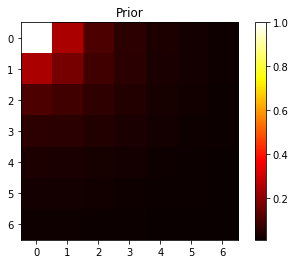

In [6]:
f = plt.figure()
show_activations(f.add_subplot(1,1,1), prior[0], "Prior")
np.sum(prior[0])

4.936214

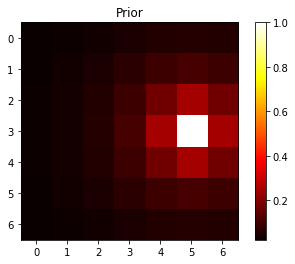

In [7]:
# More weight is given to the neurons on the right as a result of th
f = plt.figure()
show_activations(f.add_subplot(1,1,1), prior[26], "Prior")
np.sum(prior[26])

### Data loading
---

In [24]:
kwargs = {}
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True, **kwargs)
batch_num = 1

In [25]:
# Load data
for _batch_num, (data, target) in enumerate(test_loader):
    if batch_num == _batch_num:
        break
batch = data.numpy()
data, target = Variable(data, volatile=True), Variable(target)

In [26]:
local_acts = local_model(data, return_activations=True)
classic_acts  = classic_model(data, return_activations=True)

In [27]:
len(local_acts)

3

In [28]:
def get_2d_mean(activation):
    activation = activation/np.sum(activation)
    coords = local.make_idx_arr(7,7)
    weighted_coords = np.multiply(coords, np.reshape(activation, (7,7,1)))
    weighted_coords = np.reshape(weighted_coords, (-1,2))
    return np.sum(weighted_coords, axis=0)

In [29]:
def get_2d_variance(activation):
    mean = get_2d_mean(activation)
    activation = activation/np.sum(activation)
    activation = np.reshape(activation, (7,7,1))
    coords = local.make_idx_arr(7,7)
    dists = activation * (coords - mean)**2
    unbias_weight = 1./(1.-np.sum(activation**2))
    return unbias_weight * np.sum(dists)

In [30]:
def show(local_activations, classic_activations, target, i, 
         variances, counts, activations=[]):
    f = plt.figure(figsize=(12, 3))
    # f, axarr = plt.subplots(1, 3)
    ax = f.add_subplot(1, 3, 1)
    idx = (target.data.numpy()==i).argmax()
    ax.imshow(batch[idx][0])
    act_local = average_activations(
                    local_activations, 
                    target.data.numpy(),
                    i)
    act_classic = average_activations(
                    classic_activations, 
                    target.data.numpy(),
                    i)
    v_local = get_2d_variance(act_local)
    v_classic = get_2d_variance(act_classic)
    variances.append((v_local, v_classic))
    activations.append((act_local.mean(), act_classic.mean()))
    counts.append(idx.sum())
    
#     print "Center (local):", get_2d_mean(act_local)
#     print "Variance (local):", v_local
#     print "Center (classic):", get_2d_mean(act_classic)
#     print "Variance (classic):", v_classic
    show_activations(f.add_subplot(1,3,2),
                 act_local,
                 "Local")
    show_activations(f.add_subplot(1,3,3),
                 act_classic,
                 "Classic")
    plt.show()


In [31]:
def plot_variances(variances, counts):
    print "Variances:", np.sum(np.array(variances) * np.array(counts)[:,np.newaxis], axis=0)
    N = 10
    width = 0.35       # the width of the bars

    ind = np.arange(N)  # the x locations for the groups
    local_variances, classic_variances = zip(*variances)
    print stats.ttest_rel(local_variances, classic_variances)
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, local_variances, width, color='r')
    rects2 = ax.bar(ind + width, classic_variances, width, color='y')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Variances')
    ax.set_title('Variance by class and model')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels([str(k) for k in ind])

    ax.legend((rects1[0], rects2[0]), ('Local', 'Control'))


    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.show()

## FC1
--- 

FC1
N: 76
N: 76


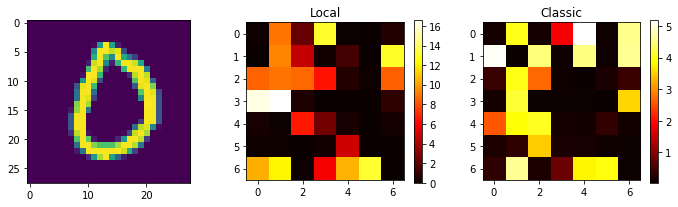

N: 120
N: 120


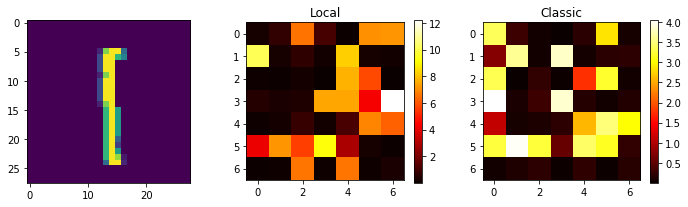

N: 95
N: 95


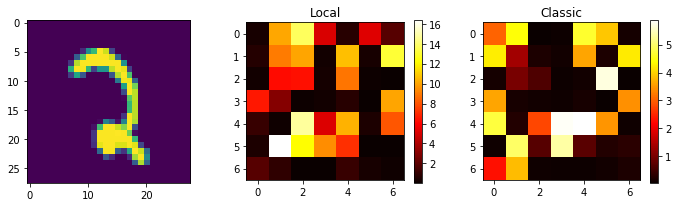

N: 100
N: 100


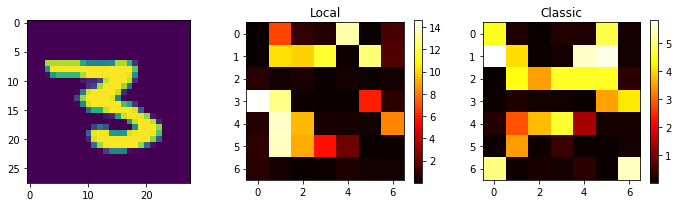

N: 107
N: 107


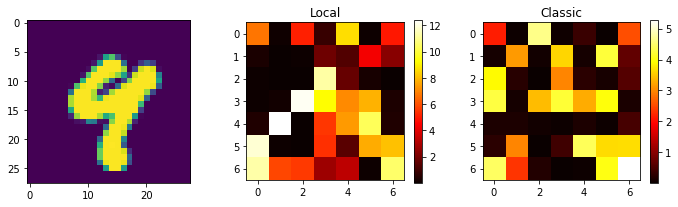

N: 86
N: 86


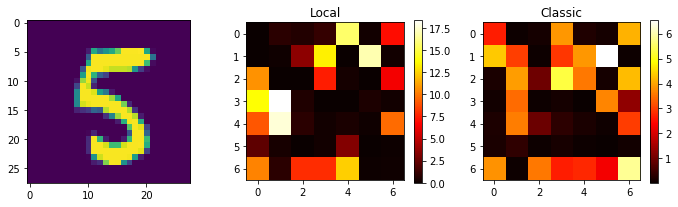

N: 100
N: 100


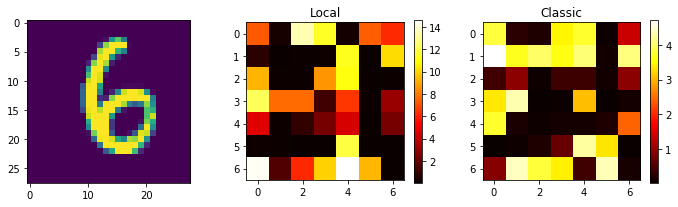

N: 105
N: 105


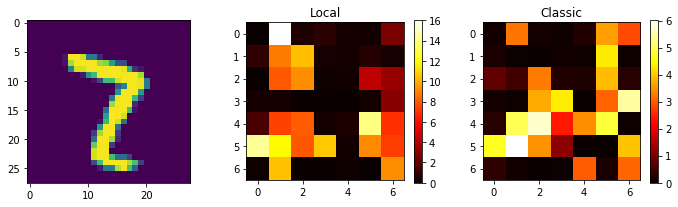

N: 99
N: 99


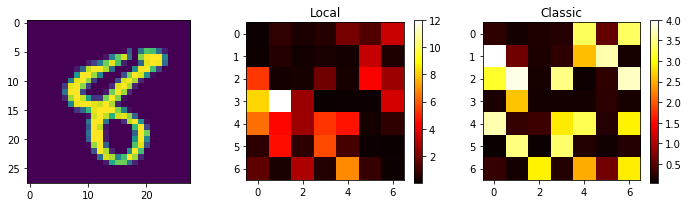

N: 112
N: 112


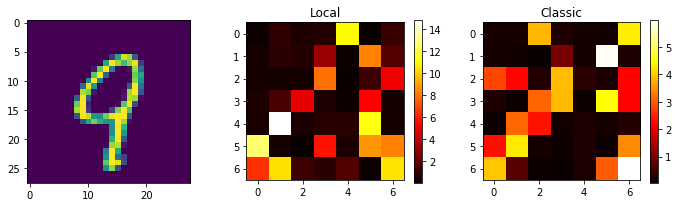

Variances: [ 535.87052389  586.65053803]
Ttest_relResult(statistic=-2.1582038589444128, pvalue=0.059240419793845291)


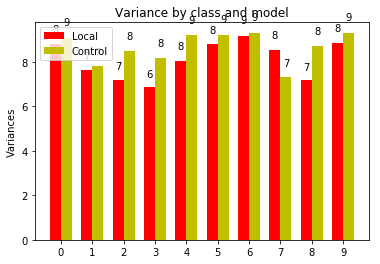

In [32]:
print "FC1"
layer = 0
local_activations = local_acts[layer].data.numpy()
classic_activations = classic_acts[layer].data.numpy()
layer_1_class_activations = []
layer_1_variances = []
layer_1_counts = []
for i in range(10):
    show(local_activations, classic_activations, target, i, 
         layer_1_variances, layer_1_counts, layer_1_class_activations)
plot_variances(layer_1_variances, layer_1_counts)

Variances: [ 236.22398591  113.52424073]
Ttest_relResult(statistic=10.800105889365449, pvalue=1.8788654089684479e-06)


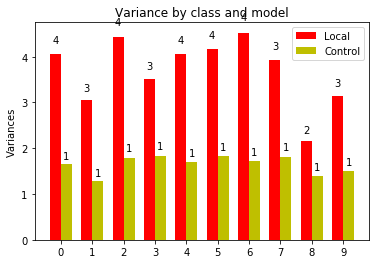

In [33]:
plot_variances(layer_1_class_activations, layer_1_counts)

In [34]:
print np.mean(local_activations), np.mean(classic_activations)
print stats.ttest_rel(
    np.mean(local_activations, axis=1),
    np.mean(classic_activations, axis=1))

3.66939 1.64225
Ttest_relResult(statistic=41.855821683657126, pvalue=5.811757682880791e-222)


## FCLocal
---

FCLocal
N: 76
N: 76


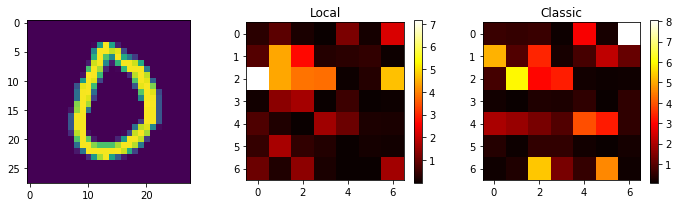

N: 120
N: 120


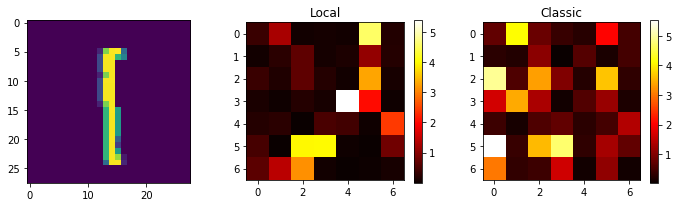

N: 95
N: 95


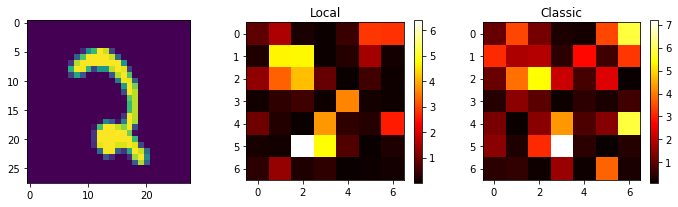

N: 100
N: 100


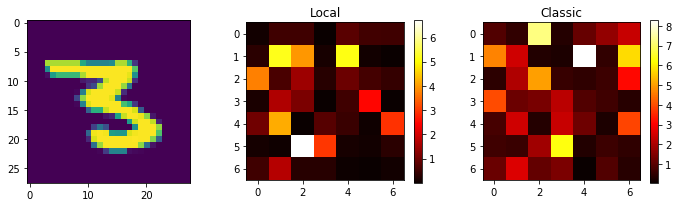

N: 107
N: 107


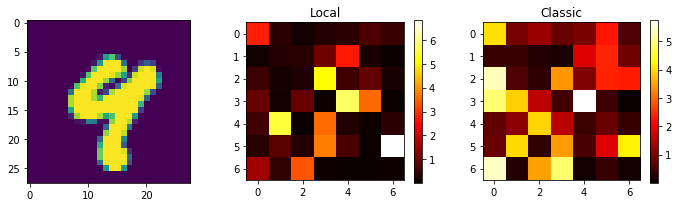

N: 86
N: 86


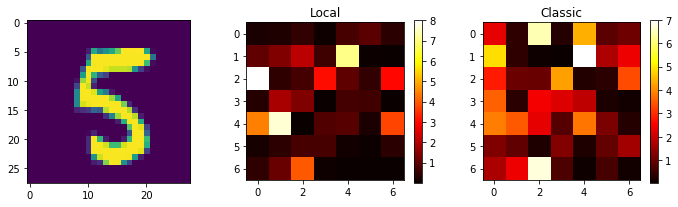

N: 100
N: 100


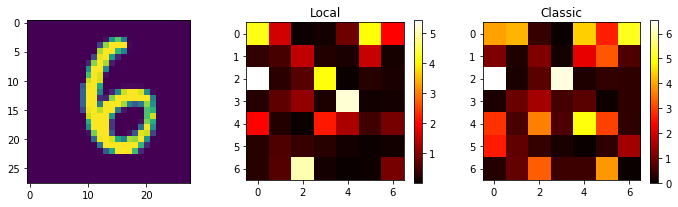

N: 105
N: 105


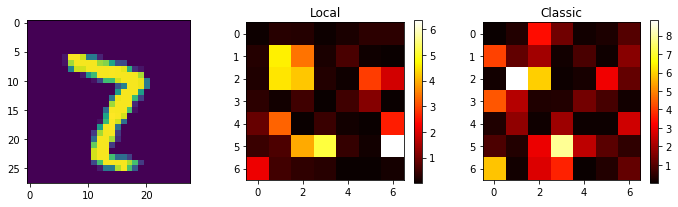

N: 99
N: 99


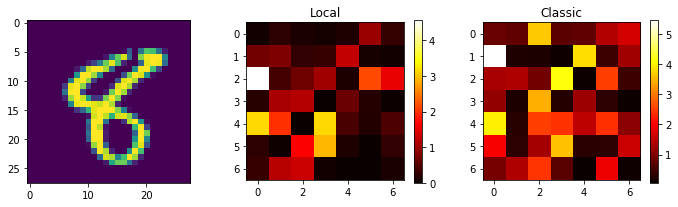

N: 112
N: 112


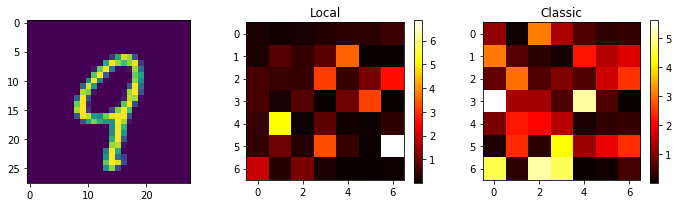

Variances: [ 497.88580006  560.47619056]
Ttest_relResult(statistic=-5.1263807117994453, pvalue=0.00062260366687258266)


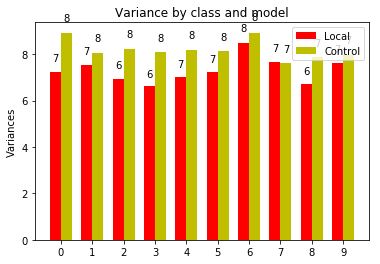

In [35]:
print "FCLocal"
layer = 1
local_activations = local_acts[layer].data.numpy()
classic_activations = classic_acts[layer].data.numpy()
layer_local_variances = []
layer_local_counts = []
for i in range(10):
    show(local_activations, classic_activations, target, i, 
         layer_local_variances, layer_local_counts)
plot_variances(layer_local_variances, layer_local_counts)

In [36]:
layer = 1
local_activations = local_acts[layer].data.numpy()
classic_activations = classic_acts[layer].data.numpy()

In [37]:
variances = []
counts = []

for k, _ in enumerate(target.data.numpy()):
    l = local_activations[k]
    c = classic_activations[k]
    variances.append((get_2d_variance(l), get_2d_variance(c)))

local_variances, classic_variances = zip(*variances)
print stats.ttest_rel(local_variances, classic_variances)

Ttest_relResult(statistic=-20.245235680257011, pvalue=1.2334248540419829e-76)


In [38]:
print stats.ttest_rel(
    np.mean(local_activations, axis=1),
    np.mean(classic_activations, axis=1))
# np.mean(local_activations), np.mean(classic_activations)

Ttest_relResult(statistic=-23.679481767864921, pvalue=9.5475539068453537e-99)
